In [ ]:
!pip install opencv-python-headless
#!pip install -U "tensorflow>=2.10.0"
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [ ]:
import cv2
import os
import pandas as pd

import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz
import random
import shutil
import glob

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import keras
from keras import layers

In [ ]:
#Mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")
#/content/drive/MyDrive/csvs/

Mounted at /content/drive


# The prepared dataset:
In order to hypertune the model, only a fraction of the dataset (40%) was used. However, for the final model, the complete subsets created in the "EDA_HAB.ipynb" (saved in folder "cleaned_actions") were used.

This code refers to training the model with the complete training dataset.

In [ ]:
# The original dataset:
#dataset_path = os.listdir('/content/drive/My Drive/csvs/handball_s/actions')

# The new directory, created to preserve the original, is "cleaned_actions".
# The train, test, and validation dataset were created from this copy "cleaned_actions".
dataset_path = os.listdir('/content/drive/My Drive/csvs/handball_test/cleaned_actions')

label_types = os.listdir('/content/drive/My Drive/csvs/handball_test/cleaned_actions')
print(label_types)

['jump-shot', 'passing', 'crossing', 'defence', 'shot']


In [ ]:
# Define the paths to the dataset folders
#dataset_path = '/content/drive/My Drive/csvs/handball_s/actions'
dataset_path = '/content/drive/My Drive/csvs/handball_test/cleaned_actions'

train_path = '/content/drive/My Drive/csvs/handball_test/train'
test_path = '/content/drive/My Drive/csvs/handball_test/test'
val_path = '/content/drive/My Drive/csvs/handball_test/val'

# Extracting frame from video:
Source of functions for loading video: https://www.tensorflow.org/tutorials/load_data/video

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame


In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 7):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(os.path.basename(p) for p in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, p))))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
      video_paths = glob.glob(os.path.join(self.path, '*/*.avi'))
      classes = [os.path.basename(os.path.dirname(p)) for p in video_paths]
      return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label


Trying the functions...

In [ ]:
fg = FrameGenerator(train_path, 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")


Shape: (10, 224, 224, 3)
Label: 0


## Creating the tensors datasets:

Defining Constants:
*   n_frames = 10: Specifies the number of frames to be extracted from each video.
*   output_signature: This variable defines the structure of the output of the generator function that creates the dataset. It specifies the shape and data type of the output tensors.
In this case, the output signature consists of a tuple containing two elements:

    - The first element is a tensor with shape (None, None, None, 3) and data type tf.float32. The first three dimensions are set to None, indicating variable size along those dimensions. This is because the frame dimensions may vary across different videos. The last dimension of size 3 represents the three color channels (assuming RGB format).

    - The second element is a scalar tensor with shape () (i.e., a scalar) and data type tf.int16. This is likely used for labeling the frames or indicating the action category.


In [ ]:
n_frames = 10

In [ ]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

### Training tensor_set:

In [ ]:
# Create the training set
train_ds = tf.data.Dataset.from_generator(FrameGenerator(train_path, n_frames, training=True),
                                          output_signature = output_signature)


In [ ]:
for frames, labels in train_ds.take(10):
  print(labels)

tf.Tensor(4, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(2, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)
tf.Tensor(1, shape=(), dtype=int16)
tf.Tensor(0, shape=(), dtype=int16)


### Validation tensor_set:

In [ ]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(val_path, n_frames),
                                        output_signature = output_signature)


### Test tensor_set:

In [ ]:
# Create the validation set
test_ds = tf.data.Dataset.from_generator(FrameGenerator(test_path, n_frames),
                                        output_signature = output_signature)


### Checking shape of tensor datasets:

In [ ]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validation set of frames: {test_frames.shape}')
print(f'Shape of validation labels: {test_labels.shape}')


Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


# Final input for the model:

## Batching the data:
The data is divided into batches to deal with efficient memory usage, to improve the training performance, to optimize the gradiente descent, and to enable efficient vectorized operations which take advantege of hardware acceleration (e.g., GPU).
*   batch_size = 4: Specifies the batch size for training, validation, and testing datasets.

> In order to train the model correctly, extra GPUs had to be purchased. Still, available GPU RAM is 16GB. Thus, batch size cannot be too big.
Either A100 or V100 GPUs were used, depending on the availability.
This purchase also granted access to TPU processing, however the available memory resources were not enough to support the code (more memory would have been to be purchased). Source: https://www.domainelibre.com/comparing-the-performance-and-cost-of-a100-v100-t4-gpus-and-tpu-in-google-colab/

A common practice is to use batch sizes that are powers of 2 (e.g., 32, 64, 128) for better performance, as many deep learning frameworks are optimized for such batch sizes.

In [ ]:
batch_size = 4

In [ ]:
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

test_frames, test_labels = next(iter(test_ds))
print(f'Shape of training set of frames: {test_frames.shape}')
print(f'Shape of training labels: {test_labels.shape}')


Shape of training set of frames: (4, 10, 224, 224, 3)
Shape of training labels: (4,)
Shape of validation set of frames: (4, 10, 224, 224, 3)
Shape of validation labels: (4,)
Shape of training set of frames: (4, 10, 224, 224, 3)
Shape of training labels: (4,)


## Optimizing the performance of input data pipelines in TensorFlow using the `tf.data` API

Using buffered prefetching one can yield data from the disk without having Input/Output become blocking. Two important functions to use while loading data are:
  * Dataset.**cache**: keeps the sets of frames in memory after they're loaded off the disk during the first epoch. This function ensures that the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, one can also use this method to create a performant on-disk cache.
  
  * Dataset.**shuffle(1000)**: shuffles the elements of the dataset with a buffer size of 1000.

  * Dataset.**prefetch**: overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

#  .shuffle(1000) method shuffles the elements of the dataset with a buffer size of 1000.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

To sum up:
This code snippet optimizes the performance of TensorFlow input pipelines by reducing data loading time, introducing randomness into the training process, and overlapping data preprocessing with model execution, to improve overall throughput

# Model

## Building the model:
The model is structured into blocks to make it easier to **understand**

In [ ]:
def get_model(num_classes, depth=n_frames, width=224, height=224):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth, width, height, 3))

    x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPool3D(pool_size=(1, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=(3,3,3), activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=(1, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=(3,3,3), activation="relu", padding="same")(x)
    x = layers.MaxPool3D(pool_size=(1, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=(3,3,3), activation="relu", padding="valid")(x)
    x = layers.MaxPool3D(pool_size=(1, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=512, kernel_size=(3,3,3), activation="relu", padding="valid")(x)
    x = layers.MaxPool3D(pool_size=(1, 2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(units=32, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=num_classes, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model_3dcnn = get_model(num_classes=len(label_types), depth=n_frames, width=224, height=224)
#model_3dcnn.summary()


## Training the model:

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model_3dcnn.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
    run_eagerly=True,
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_video_classification.keras", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)


In [ ]:
# Train the model, doing validation at the end of each epoch
epochs = 100
history = model_3dcnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
126/126 - 77s - loss: 1.4497 - acc: 0.3929 - val_loss: 4.8357 - val_acc: 0.1944 - 77s/epoch - 609ms/step
Epoch 2/100
126/126 - 17s - loss: 1.2173 - acc: 0.5159 - val_loss: 6.9566 - val_acc: 0.1944 - 17s/epoch - 133ms/step
Epoch 3/100
126/126 - 17s - loss: 1.1181 - acc: 0.5675 - val_loss: 7.1126 - val_acc: 0.1944 - 17s/epoch - 137ms/step
Epoch 4/100
126/126 - 18s - loss: 1.0285 - acc: 0.5992 - val_loss: 3.6035 - val_acc: 0.1944 - 18s/epoch - 141ms/step
Epoch 5/100
126/126 - 21s - loss: 0.9226 - acc: 0.6587 - val_loss: 0.8538 - val_acc: 0.6806 - 21s/epoch - 170ms/step
Epoch 6/100
126/126 - 17s - loss: 0.8254 - acc: 0.6984 - val_loss: 1.5603 - val_acc: 0.5556 - 17s/epoch - 134ms/step
Epoch 7/100
126/126 - 17s - loss: 0.7941 - acc: 0.7282 - val_loss: 0.9524 - val_acc: 0.6389 - 17s/epoch - 135ms/step
Epoch 8/100
126/126 - 17s - loss: 0.7042 - acc: 0.7480 - val_loss: 0.7254 - val_acc: 0.7500 - 17s/epoch - 137ms/step
Epoch 9/100
126/126 - 17s - loss: 0.6799 - acc: 0.7738 - val_los

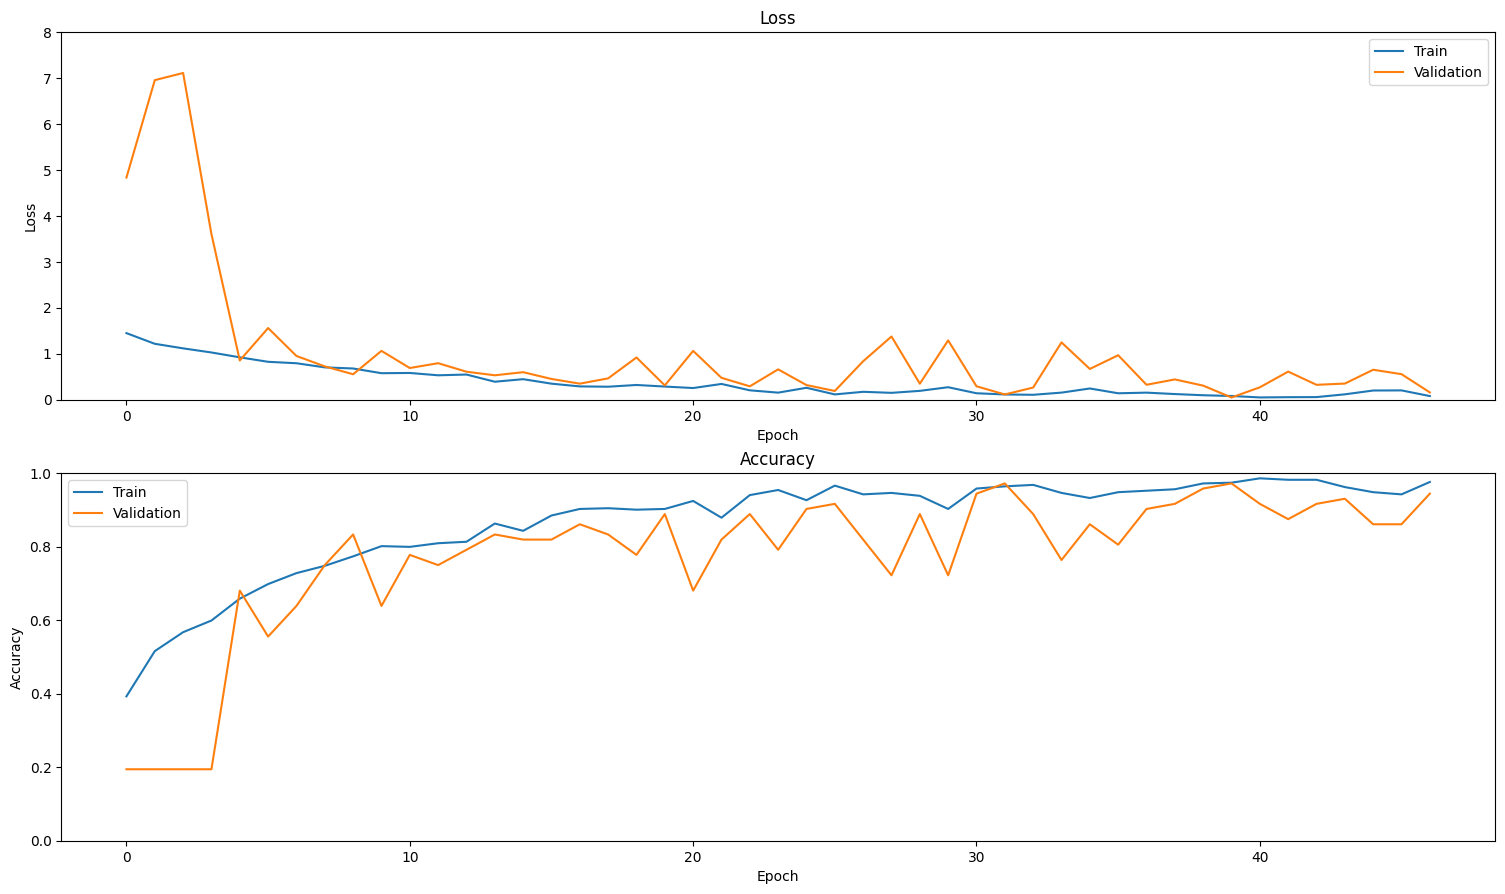

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['acc'],  label = 'train')
  ax2.plot(history.history['val_acc'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

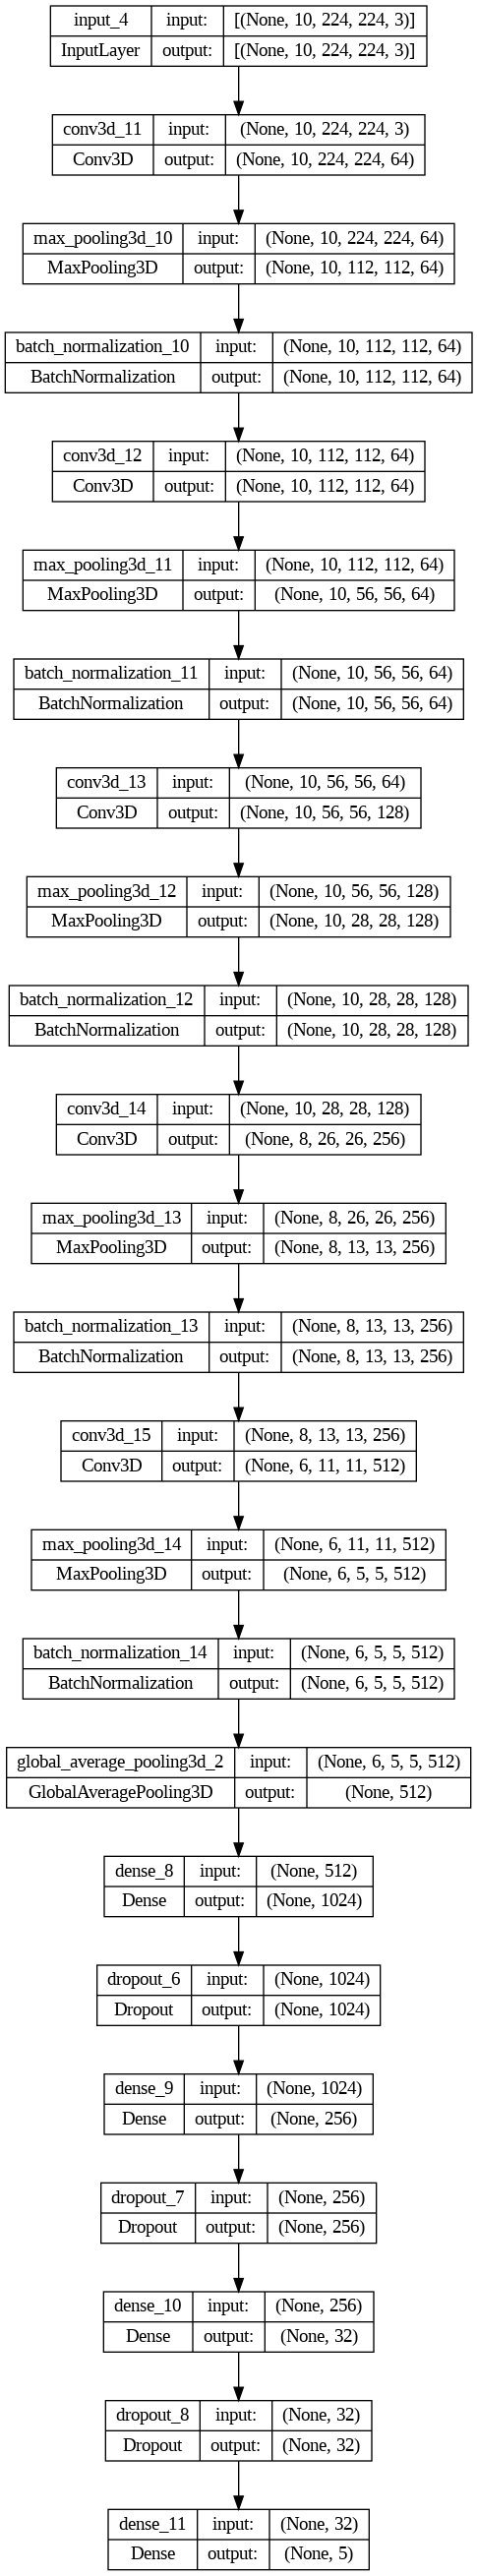

In [ ]:
plot_model(model_3dcnn, show_shapes=True, show_layer_names=True)

#### Evaluating the 3D-CNN model:

In [ ]:
model_3dcnn.evaluate(test_ds, return_dict=True)

37/37 [==============================] - 138s 63ms/step - loss: 0.5147 - acc: 0.9178


{'loss': 0.5147130489349365, 'acc': 0.9178082346916199}

**Building a confusion matrix:**<br>
The confusion matrix allows to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values.

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  # for input_data, label in dataset.take(1):
  #   print("Input Data:", input_data)
  #   print("Label:", label)


  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model_3dcnn.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted


In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(6, 6)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)


In [ ]:
labels = label_types

126/126 [==============================] - 5s 41ms/step


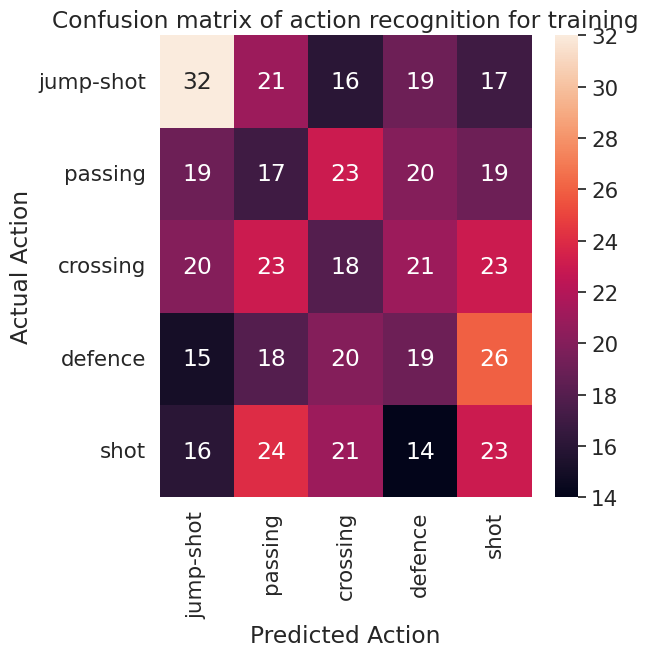

In [ ]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

37/37 [==============================] - 1s 40ms/step


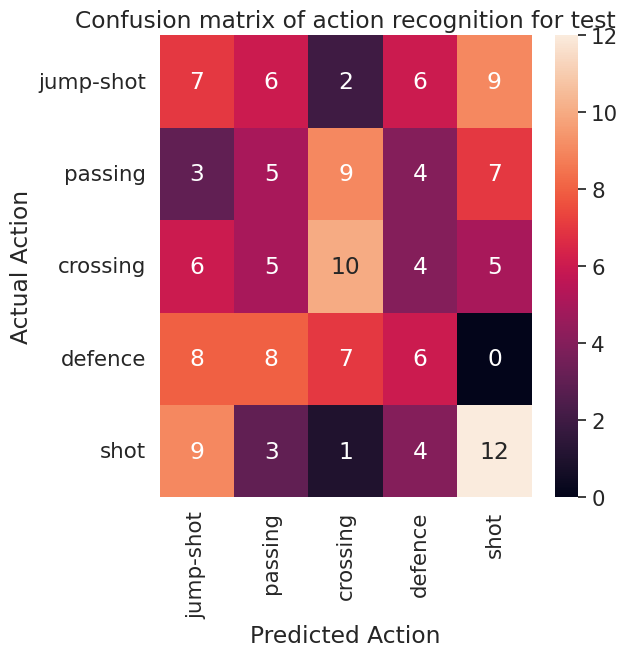

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall


In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
print("Precision of CNN - based model: ")
print(precision)

print("/nRecall of CNN - based model: ")
print(recall)

Precision of CNN - based model: 
{'jump-shot': 0.21212121212121213, 'passing': 0.18518518518518517, 'crossing': 0.3448275862068966, 'defence': 0.25, 'shot': 0.36363636363636365}
/nRecall of CNN - based model: 
{'jump-shot': 0.23333333333333334, 'passing': 0.17857142857142858, 'crossing': 0.3333333333333333, 'defence': 0.20689655172413793, 'shot': 0.41379310344827586}


# Saving models:
The models will be saved in the TensorFlow SavedModel format.

In [ ]:
path_to_save_model = '/content/drive/My Drive/csvs/handball_test/models/3d_cnn'

In [ ]:
model = model_3dcnn

In [ ]:
#Save the model in TensorFlow SavedModel format
tf.saved_model.save(model, path_to_save_model)
